## Vehicle Detection Project

In [1]:
# Pipeline for Project 5
# 1. Extract Features from images
# 2. Train Classifier
# 3. Sliding window to make detections in images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pdb
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import time
test_mode = True

/Users/Akshay/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Method for printing images
def print_image(img, title = ""):
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.title(title)
    
def print_gray_image(img, title = ""):
    plt.figure(figsize=(7, 7))
    plt.imshow(img, cmap="gray")
    plt.title(title)

In [3]:
# Read in our vehicles and non-vehicles
cars = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/feature_extraction_data/vehicles/*.jpeg')
notcars = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/feature_extraction_data/non-vehicles/*.jpeg')

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='RGB', 
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     hog_channel=0,
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        spatial_features = bin_spatial(feature_image, size = spatial_size)
        hist_features = color_hist(feature_image, nbins = hist_bins, bins_range = hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

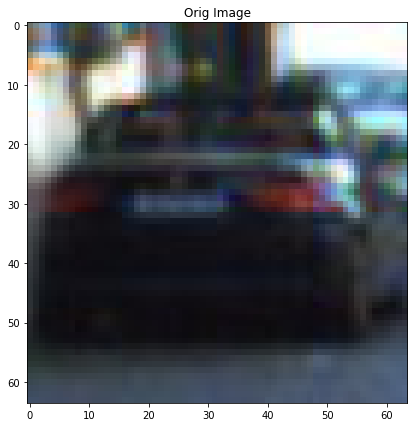

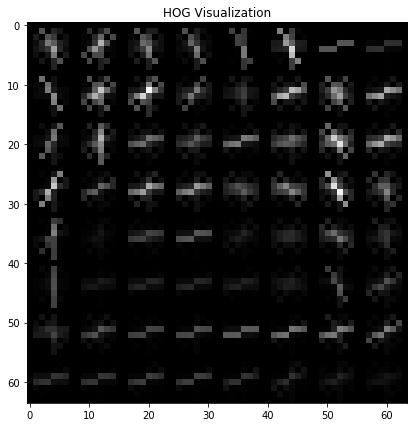

In [8]:
if test_mode:
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    image = mpimg.imread(cars[ind])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    hog_features, hog_image = get_hog_features(gray,
                                               orient,
                                               pix_per_cell,
                                               cell_per_block,
                                               vis=True,
                                               feature_vec=False)

    print_image(image, 'Orig Image')
    print_gray_image(hog_image, 'HOG Visualization')

In [9]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 16

t=time.time()
car_features = extract_features(cars, 
                                cspace = colorspace, 
                                orient = orient, 
                                pix_per_cell = pix_per_cell, 
                                cell_per_block = cell_per_block, 
                                hog_channel = hog_channel,
                                spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))

notcar_features = extract_features(notcars, 
                                   cspace = colorspace, 
                                   orient = orient, 
                                   pix_per_cell = pix_per_cell, 
                                   cell_per_block = cell_per_block, 
                                   hog_channel = hog_channel,
                                   spatial_size=(spatial, spatial),
                                   hist_bins=histbin, hist_range=(0, 256))

t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector. 1 if car present and 0 if not
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

14.38 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
1.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9871
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
0.0037 Seconds to predict 10 labels with SVC
